# Gaussian Processes

Week 8 is about Bayesian nonparametrics and stochastic processes, starting with Gaussian processes. This notebook is a demo relating a Bayesian linear regression with RBF features to a squared exponential kernel. 

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# Pull the data from HW 1
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw1/hw1.pt
Xs, ys = torch.load("hw1.pt")

# Recall that X is a (N, 2) tensor where the first column is all ones
# We just want the x locations (the second column)
xs = Xs[:, 1]

zsh:1: command not found: wget


Text(0, 0.5, '$y$')

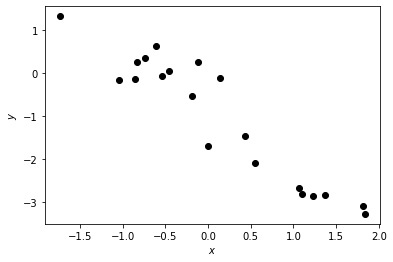

In [3]:
# Plot the data
plt.plot(xs, ys, 'ko')
plt.xlabel("$x$")
plt.ylabel("$y$")

## Linear regression with RBF basis functions

Let's start with a Bayesian linear regression using an RBF feature encoding,

$$
\begin{align}
\phi_p(x) &= e^{-\frac{1}{2\ell^2} (x - c_p)^2 } 
\end{align}
$$

with center $c_p$ and width $\ell$. The model was,

$$
\begin{align}
y_n &\sim \mathcal{N}\left( \sum_p w_p \phi_p(x_n), \sigma^2 \right)
\end{align}
$$

where 

$$
\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, \lambda I).
\end{align}
$$

First, let's look at the basis with different numbers of basis functions.

In [4]:
# Set up a finite RBF basis
def rbf(x, center, length_scale):
    return torch.exp(-0.5 / length_scale**2 * (x - center)**2)

def plot_basis(num_basis, xlim=5, length_scale=1.0):
    centers = torch.linspace(-xlim, xlim, num_basis)
    x_grid = torch.linspace(-xlim, xlim, 500)
    for center in centers:
        plt.plot(x_grid, rbf(x_grid, center, length_scale))
    
    plt.xlabel("$x$")
    plt.ylabel("$y$")


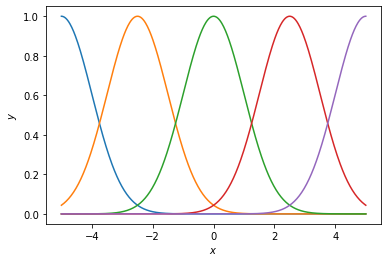

In [5]:
plot_basis(5)

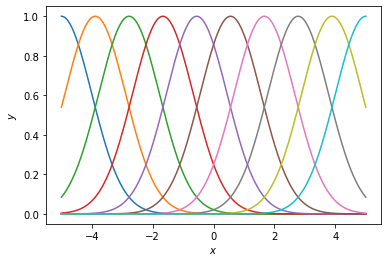

In [6]:
plot_basis(10)

## Now fit a linear regression with this basis

We will first compute the posterior $p(\mathbf{w} \mid \{x_n, y_n\}_{n=1}^N)$, then we'll use it to predict $y_{N+1}$ for a grid of points $x_{N+1}$. 

In [7]:
def fit_rbf_regression(xs, ys, 
                       xlim=5,
                       num_basis=10,
                       length_scale=1.0,
                       prior_var=1.0,
                       lkhd_var=0.5**2):
    """Fit a Bayesian linear regression with an RBF feature encoding.
    
    Parameters
    ----------
    xs, ys: 1D inputs and outputs of the regression
    xlim: max absolute value of the RBF centers
    num_basis: number of RBF features, evenly spaced between +/-xlim
    length_scale: length_scale of the RBF kernels
    prior_var: prior variance of the weights
    lkhd_var: variance of the likelihood y ~ N(w \cdot \phi(x), sigma^2)
    """
    centers = torch.linspace(-xlim, xlim, num_basis)

    # Encode the data in the RBFs. 
    encoded_xs = rbf(xs[:, None], centers[None, :], length_scale)

    # Assuming fixed and likelihood variances, compute the posterior 
    # distribution of the weights
    J_post = num_basis / prior_var * torch.eye(num_basis) \
           + encoded_xs.T @ encoded_xs / lkhd_var
    h_post = encoded_xs.T @ ys / lkhd_var
    Sigma_post = torch.linalg.inv(J_post)
    mu_post = Sigma_post @ h_post

    # Compute the predictive mean at a dense grid of points
    x_grid = torch.linspace(-xlim, xlim, 100)
    encoded_grid = rbf(x_grid[:, None], centers[None, :], length_scale)
    mu_pred = encoded_grid @ mu_post
    Sigma_pred = encoded_grid @ Sigma_post @ encoded_grid.T \
        + lkhd_var * torch.eye(100)

    # Plot the mean and +-3 standard deviations of the posterior
    for i in range(1, 4):
        plt.fill_between(x_grid, 
                        mu_pred - i * torch.sqrt(torch.diag(Sigma_pred)),
                        mu_pred + i * torch.sqrt(torch.diag(Sigma_pred)),
                        color='r', alpha=0.1)
    plt.plot(x_grid, mu_pred, '-r', lw=3)
    plt.plot(xs, ys, 'o')
    plt.xlabel("$x$")
    plt.xlim(-xlim, xlim)
    plt.ylabel("$y$")

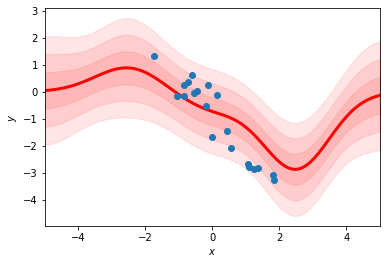

In [8]:
fit_rbf_regression(xs, ys, num_basis=5)

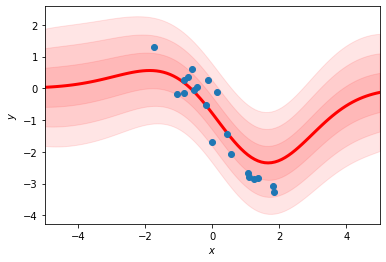

In [9]:
fit_rbf_regression(xs, ys, num_basis=10)

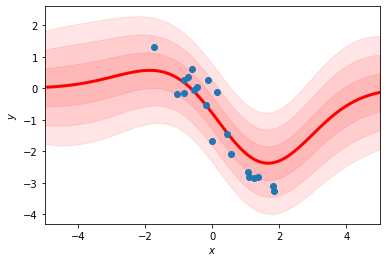

In [10]:
fit_rbf_regression(xs, ys, num_basis=20)

### Questions
- Why are the mean and variance of the predictions more "wiggly" in the first plot?
- Why do the predicted means decay back to zero as $|x|$ increases rather than following the linear trend of the data?
- What would happen if we increased the prior variance?
- What would happen if we increased the likelihood variance?

## Now use a Gaussian process with a squared exponential kernel

In class we introduced the squared exponential kernel 

$$
\begin{align}
K(x_i, x_j) &= \varsigma^2 e^{-\frac{1}{2 \ell'^2} (x_i - x_j)^2}
\end{align}
$$

with variance $\varsigma^2$ and length scale $\ell'$. We showed how it arises from Bayesian linear regression with an encoding into an infinite set of radial basis functions.  Concretely, the squared exponential kernel with variance $\varsigma^2 = \sqrt{\pi} \ell \lambda$ and length scale $\ell' = \sqrt{2} \ell$ is the infinite limit of the RBF regression.

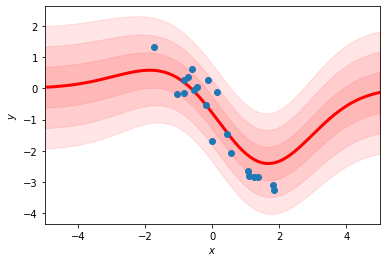

In [11]:
def fit_sqexp_gp(xs, ys, 
                 length_scale=1.0,
                 prior_var=1.0,
                 lkhd_var=0.5**2,
                 xlim=5.0):
    N = len(xs)
    
    # Define the squared exponential kernel function. Account for the scaling
    # constants necessary to equate with the RBF regression
    def kernel(x_i, x_j): 
        scale = 0.1 * torch.sqrt(torch.tensor(torch.pi)) * length_scale * prior_var
        return scale * torch.exp(-0.5 / (torch.sqrt(torch.tensor(2)) * \
                                         length_scale)**2 * (x_i - x_j)**2)

    # Compute the Gram matrix
    K = kernel(xs[:, None], xs[None, :])

    # Compute the predictive mean at a dense grid of points
    x_grid = torch.linspace(-xlim, xlim, 1000)
    K_grid = kernel(xs[:, None], x_grid[None, :]) 

    K_chol = torch.linalg.cholesky(K + lkhd_var * torch.eye(N))
    mu_pred = K_grid.T @ torch.cholesky_solve(ys[:, None], K_chol)[:, 0]
    Sigma_pred = kernel(x_grid[:, None], x_grid[None, :]) \
        - K_grid.T @ torch.cholesky_solve(K_grid, K_chol) + lkhd_var * torch.eye(1000)
    
    # Plot the mean and +-3 standard deviations of the posterior
    for i in range(1, 4):
        plt.fill_between(x_grid, 
                         mu_pred - i * torch.sqrt(torch.diag(Sigma_pred)),
                         mu_pred + i * torch.sqrt(torch.diag(Sigma_pred)),
                         color='r', alpha=0.1)
    plt.plot(x_grid, mu_pred, '-r', lw=3)
    plt.plot(xs, ys, 'o')
    plt.xlabel("$x$")
    plt.xlim(-xlim, xlim)
    plt.ylabel("$y$")

fit_sqexp_gp(xs, ys)

### Comparison to the RBF regression 

This should look like the RBF regression as we take the number of basis functions to infinity.

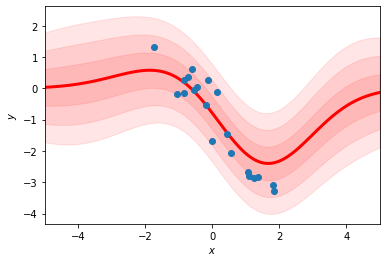

In [12]:
fit_rbf_regression(xs, ys, num_basis=100)

### Questions
- What happens if you increase the prior variance?
- What happens if you _decrease_ the likelihood variance?
- What happens if you _decrease_ the length scale?

# GP Classification with a Probit Mean Function

First, let's visualize the joint distribution over $f(x)$ and $z$, assuming

$$
\begin{align}
f(x) &\sim \mathcal{N}(0, 1) \\
z &\sim \mathcal{N}(f(x), 1) \cdot \mathbb{I}[z > 0]
\end{align}
$$

/Users/scott/miniconda3/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


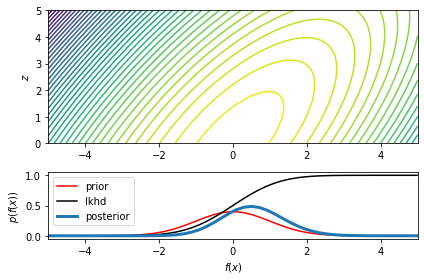

In [13]:
# Make a g
xlim = 5
x_grid = torch.linspace(-xlim, xlim, 50)
z_grid = torch.linspace(0, xlim, 50)
XX, ZZ = torch.meshgrid(x_grid, z_grid)

# Compute the log joint probability
lp_xz = torch.distributions.Normal(0, 1).log_prob(XX)
lp_xz += torch.distributions.Normal(XX, 1).log_prob(ZZ)
lp_xz -= torch.logsumexp(lp_xz, (0, 1))
# p_xz = torch.exp(lp_xz)

# Compute the marginal
lp_x = torch.logsumexp(lp_xz, axis=1)
lp_x -= (torch.logsumexp(lp_x, 0) + torch.log(x_grid[1] - x_grid[0]))
lp_x_prior = torch.distributions.Normal(0, 1).log_prob(x_grid)
lp_x_lkhd = torch.distributions.Normal(0, 1).cdf(x_grid)

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 1, height_ratios=(2, 1))
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
ax1.contour(XX, ZZ, lp_xz, 50)
ax1.set_ylabel("$z$")

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(x_grid, torch.exp(lp_x_prior), '-r', label="prior")
ax2.plot(x_grid, lp_x_lkhd, '-k', label="lkhd")
ax2.plot(x_grid, torch.exp(lp_x), lw=3, label="posterior")
ax2.set_xlabel("$f(x)$")
ax2.set_ylabel("$p(f(x))$")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.savefig("probit.pdf")